In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1QTi7dJtNAfFR5mG0rd8K3ZGvEIfSn_DS


Downloading...
From: https://drive.google.com/uc?id=1QTi7dJtNAfFR5mG0rd8K3ZGvEIfSn_DS
To: /content/PersianData.zip
100% 7.46k/7.46k [00:00<00:00, 23.2MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('PersianData.zip', 'r') as zip_ref:
    zip_ref.extractall('trainData')


In [ ]:
import os
from PIL import Image, ImageDraw
import random

# Create 5 folders named noisy_1 to noisy_5
folder_name = "noisy_test"
os.makedirs(folder_name, exist_ok=True)  # exist_ok=True prevents error if folder exists

In [ ]:
from PIL import Image, ImageDraw
import random

def convertImageToBinary(path):
    """
    Convert an image to a binary representation based on pixel intensity.

    Args:
        path (str): The file path to the input image.

    Returns:
        list: A binary representation of the image where white is represented by -1 and black is represented by 1.
    """
    # Open the image file.
    image = Image.open(path)

    # Create a drawing tool for manipulating the image.
    draw = ImageDraw.Draw(image)

    # Determine the image's width and height in pixels.
    width = image.size[0]
    height = image.size[1]

    # Load pixel values for the image.
    pix = image.load()

    # Define a factor for intensity thresholding.
    factor = 100

    # Initialize an empty list to store the binary representation.
    binary_representation = []

    # Loop through all pixels in the image.
    for i in range(width):
        for j in range(height):
            # Extract the Red, Green, and Blue (RGB) values of the pixel.
            red = pix[i, j][0]
            green = pix[i, j][1]
            blue = pix[i, j][2]

            # Calculate the total intensity of the pixel.
            total_intensity = red + green + blue

            # Determine whether the pixel should be white or black based on the intensity.
            if total_intensity > (((255 + factor) // 2) * 3):
                red, green, blue = 255, 255, 255  # White pixel
                binary_representation.append(-1)
            else:
                red, green, blue = 0, 0, 0  # Black pixel
                binary_representation.append(1)

            # Set the pixel color accordingly.
            draw.point((i, j), (red, green, blue))

    # Clean up the drawing tool.
    del draw

    # Return the binary representation of the image.
    return binary_representation

In [ ]:
from PIL import Image, ImageDraw
import random

def generateNoisyImages():
    # List of image file paths
    image_paths = [
        "/content/trainData/1.jpg",
        "/content/trainData/2.jpg",
        "/content/trainData/3.jpg",
        "/content/trainData/4.jpg",
        "/content/trainData/5.jpg"
    ]

    for i, image_path in enumerate(image_paths, start=1):
        noisy_image_path = f"/content/noisy_test/noisy{i}.jpg"
        getNoisyBinaryImage(image_path, noisy_image_path)
        print(f"Noisy image for {image_path} generated and saved as {noisy_image_path}")

def getNoisyBinaryImage(input_path, output_path):
    """
    Add noise to an image and save it as a new file.

    Args:
        input_path (str): The file path to the input image.
        output_path (str): The file path to save the noisy image.
    """
    # Open the input image.
    image = Image.open(input_path)

    # Create a drawing tool for manipulating the image.
    draw = ImageDraw.Draw(image)

    # Determine the image's width and height in pixels.
    width = image.size[0]
    height = image.size[1]

    # Load pixel values for the image.
    pix = image.load()

    # Define a factor for introducing noise.
    noise_factor = 200

    # Loop through all pixels in the image.
    for i in range(width):
        for j in range(height):
            # Generate a random noise value within the specified factor.
            rand = random.randint(-noise_factor, noise_factor)

            # Add the noise to the Red, Green, and Blue (RGB) values of the pixel.
            red = pix[i, j][0] + rand
            green = pix[i, j][1] + rand
            blue = pix[i, j][2] + rand

            # Ensure that RGB values stay within the valid range (0-255).
            if red < 0:
                red = 0
            if green < 0:
                green = 0
            if blue < 0:
                blue = 0
            if red > 255:
                red = 255
            if green > 255:
                green = 255
            if blue > 255:
                blue = 255

            # Set the pixel color accordingly.
            draw.point((i, j), (red, green, blue))

    # Save the noisy image as a file.
    image.save(output_path, "JPEG")

    # Clean up the drawing tool.
    del draw

# Generate noisy images and save them
generateNoisyImages()


Noisy image for /content/trainData/1.jpg generated and saved as /content/noisy_test/noisy1.jpg
Noisy image for /content/trainData/2.jpg generated and saved as /content/noisy_test/noisy2.jpg
Noisy image for /content/trainData/3.jpg generated and saved as /content/noisy_test/noisy3.jpg
Noisy image for /content/trainData/4.jpg generated and saved as /content/noisy_test/noisy4.jpg
Noisy image for /content/trainData/5.jpg generated and saved as /content/noisy_test/noisy5.jpg


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

class HopfieldNetwork(object):
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]

        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)

        # Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)

        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data

        self.W = W

    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn

        # Copy to avoid call by reference
        copied_data = np.copy(data)

        # Define predict list
        predicted = []
        for i in tqdm(range(len(data))):
            predicted.append(self._run(copied_data[i]))
        return predicted

    def _run(self, init_s):
        if self.asyn==False:
            """
            Synchronous update
            """
            # Compute initial state energy
            s = init_s

            e = self.energy(s)

            # Iteration
            for i in range(self.num_iter):
                # Update s
                s = np.sign(self.W @ s - self.threshold)
                # Compute new state energy
                e_new = self.energy(s)

                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = init_s
            e = self.energy(s)

            # Iteration
            for i in range(self.num_iter):
                for j in range(30):
                    # Select random neuron
                    idx = np.random.randint(0, self.num_neuron)
                    # Update s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)

                # Compute new state energy
                e_new = self.energy(s)

                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s


    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        #plt.savefig(path+"/weights.png")
        plt.show()

Start to data preprocessing...
Start to train weights...


100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


Start to data preprocessing...
Start to predict...


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Show prediction results...


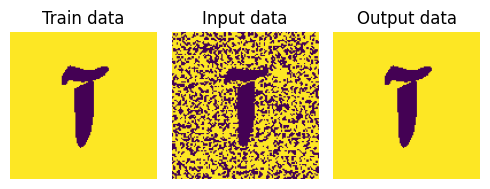

Start to data preprocessing...
Start to train weights...


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Start to data preprocessing...
Start to predict...


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Show prediction results...


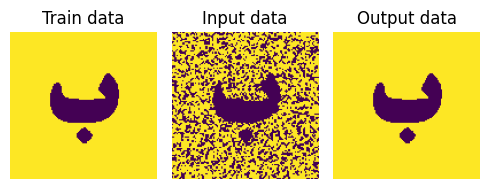

Start to data preprocessing...
Start to train weights...


100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Start to data preprocessing...
Start to predict...


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Show prediction results...


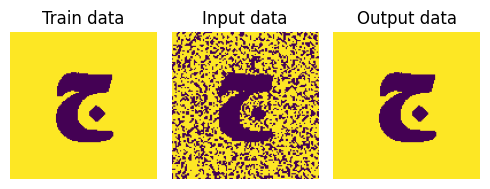

Start to data preprocessing...
Start to train weights...


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Start to data preprocessing...
Start to predict...


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Show prediction results...


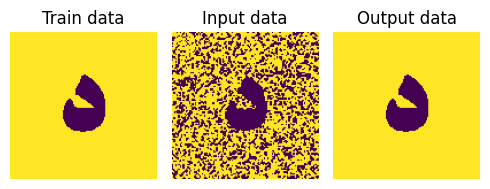

Start to data preprocessing...
Start to train weights...


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Start to data preprocessing...
Start to predict...


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Show prediction results...


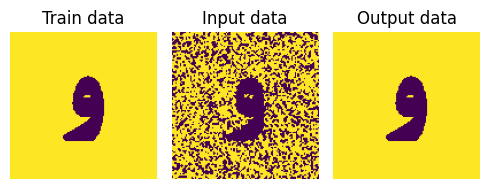

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import skimage.data
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize

# Utils
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(5, 6)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]

    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[ 0].set_title('Train data')
            axarr[ 1].set_title("Input data")
            axarr[ 2].set_title('Output data')

        axarr[ 0].imshow(data[i])
        axarr[ 0].axis('off')
        axarr[ 1].imshow(test[i])
        axarr[ 1].axis('off')
        axarr[ 2].imshow(predicted[i])
        axarr[ 2].axis('off')

    plt.tight_layout()
    plt.savefig("result.png")
    plt.show()

def preprocessing(img, w=128, h=128):
    # Resize image
    img = resize(img, (w,h), mode='reflect')

    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolian to int

    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Load data
    import cv2
    import glob

    for i in range(1,6):
      img_dir = '/content/trainData/{}.jpg'.format(i) # Enter Directory of all images
      img = rgb2gray(cv2.imread(img_dir))

      # Preprocessing
      print("Start to data preprocessing...")
      data = [preprocessing(img)]
      data = np.array(data)

      # Create Hopfield Network Model
      model = HopfieldNetwork()
      model.train_weights(data)

      # Generate testset
      #test = [get_corrupted_input(d, 0.3) for d in data]

      tst_dir = '/content/noisy_test/noisy{}.jpg'.format(i) # Enter Directory of all images
      tst = rgb2gray(cv2.imread(tst_dir))

      # Preprocessing
      print("Start to data preprocessing...")
      test = [preprocessing(tst)]
      test = np.array(test)

      predicted = model.predict(test, threshold=0, asyn=False)
      print("Show prediction results...")
      plot(data, test, predicted)
      #print("Show network weights matrix...")
      #model.plot_weights()

if __name__ == '__main__':
    main()

Start to data preprocessing...
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 438.67it/s]


Start to predict...


100%|██████████| 3/3 [00:00<00:00, 32.23it/s]

Show prediction results...


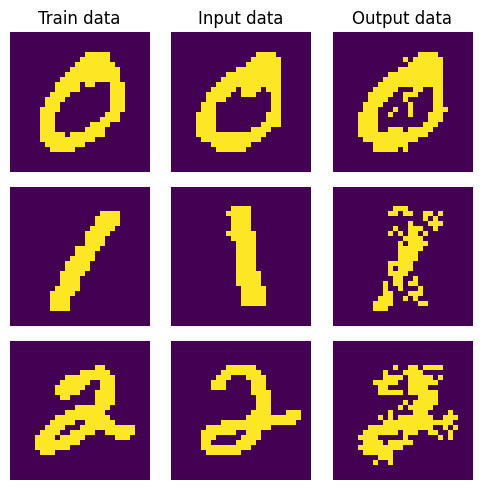

Show network weights matrix...


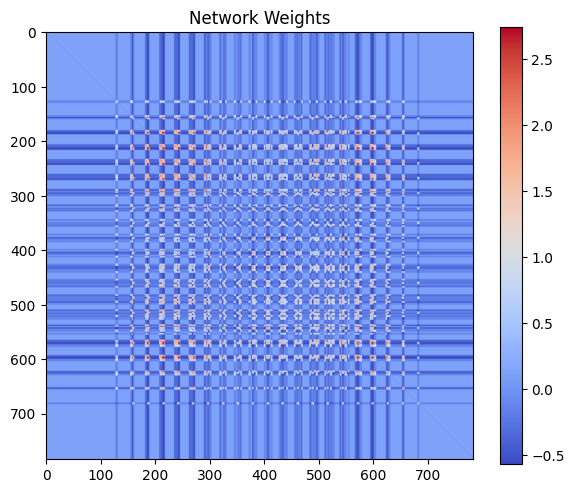

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import threshold_mean
from keras.datasets import mnist

# Utils
def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(3, 3)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]

    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')

        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig("result_mnist.png")
    plt.show()

def preprocessing(img):
    w, h = img.shape
    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolian to int

    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Load data
    (x_train, y_train), (_, _ )= mnist.load_data()
    data = []
    for i in range(3):
        xi = x_train[y_train==i]
        data.append(xi[0])

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    data = np.array(data)
    print(data)
    # Create Hopfield Network Model
    model = HopfieldNetwork()
    model.train_weights(data)

    # Make test datalist
    test = []
    for i in range(3):
        xi = x_train[y_train==i]
        test.append(xi[1])
    test = [preprocessing(d) for d in test]
    test = np.array(test)

    predicted = model.predict(test, threshold=50, asyn=True)
    print("Show prediction results...")
    plot(data, test, predicted, figsize=(5, 5))
    print("Show network weights matrix...")
    model.plot_weights()

if __name__ == '__main__':
    main()